# Dataset Creation

In [1]:
import numpy as np

import synpivimage as spi 
spi.__version__

'0.1.15'

All particle images will be written to HDF5. We will use `h5rdmtoolbox` to explore the file content:

In [2]:
import h5rdmtoolbox as h5tbx
h5tbx.__version__

'0.6.2a0'

## 1. Define an inital configuration
The initial configuration shall be the default one of the synpivimage package. From there, we adjust the parameters.<br>
Note, that the image width/height is chosen to be odd. This is recommended when using the auto-correlation feature later on.<br>
Also note, that the default configuration **disabled noise generation** since it always can be added afterwards. 

In [3]:
cfg = spi.DEFAULT_CFG

cfg['bit_depth'] = 8
cfg['nx'] = 31
cfg['ny'] = 31
cfg['sensor_gain'] = 0.6
cfg['particle_size_std'] = 1
image_size = cfg['nx']*cfg['ny']

cfg

{'ny': 31,
 'nx': 31,
 'square_image': True,
 'bit_depth': 8,
 'noise_baseline': 0.0,
 'dark_noise': 0.0,
 'sensitivity': 1,
 'qe': 1,
 'shot_noise': False,
 'particle_number': 1,
 'particle_size_mean': 2.5,
 'particle_size_std': 1,
 'laser_width': 3,
 'laser_shape_factor': 2,
 'sensor_gain': 0.6,
 'particle_position_file': None,
 'particle_size_illumination_dependency': True}

## 2. Defining parameters to be varied

Create tuples with the configuration name and the parameters. The parameter values can be a number only, a list or a numpy array (Obviously passing a number is equal to not specify the variation tuple at all).<br>
Last we specify how many images per combinations will be generated with `n_per_combination`

In [4]:
variation_dict = {'particle_number': np.arange(1, image_size*0.1, 20).astype(int),
                  'particle_size_mean': (2, 3),
                  'laser_shape_factor': (1,10)}

variation_dict

{'particle_number': array([ 1, 21, 41, 61, 81]),
 'particle_size_mean': (2, 3),
 'laser_shape_factor': (1, 10)}

## 3. Generate a list of all config combinations:

The `ConfigManager` takes the variable ranges to be varied and takes care of writing the data to (one or multipl) `HDF5` files.


This class is initalize by passing a list of all configuration dictionaries that define each image generation. Thus we need 101 configuration dictionaries. Using `build_ConfgManger()` we retrieve the `ConfigManger`-instance by passing the inital config dictionary and the variation tuples from above (so we don't need to deal with building the man config dictionaries ourselves):

In [5]:
CFGs = spi.ConfigManager.from_variation_dict(initial_cfg=cfg,
                                             variation_dict=variation_dict,
                                             per_combination = 3,
                                             shuffle=True)
CFGs

<ConfigManager (60 configurations)>

The number of configurations for the above example is computed like this: `5*2*2*3=60` where the integers are th length of lists in the `variation_dict` times the number of combination (`3`).

## 4. Write all data to HDF5 files:
With a large amount of parameters the image generation may produce arrays that will blow your RAM. Therefore define the maximal number of images to be created before written to the file. This parameter is called `n_split`. If using `None`, all data is written into a single file. If you pass any integer number, then that number of files will be created. Filenames will look like `<dataset_dir>/ds_000001.hdf` and so on.

In [6]:
%%time
hdf_filename = CFGs.generate(data_directory='example_data_dir', nproc=4, n_split=1000, overwrite=True)

Writing 60 dataset into 1 HDF5 file(s). This may take a while...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:05<00:00, 10.12it/s]


Processing standard names...
... done.
CPU times: total: 31.2 ms
Wall time: 6.13 s


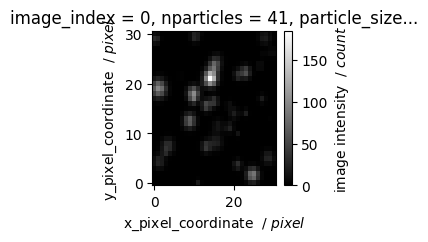

In [9]:
with h5tbx.File(hdf_filename[0], 'r') as h5:
    h5.dump()
    h5['images'][0, :, :].plot(cmap='gray', size=2, aspect=1)

Plot particle image and labels together:

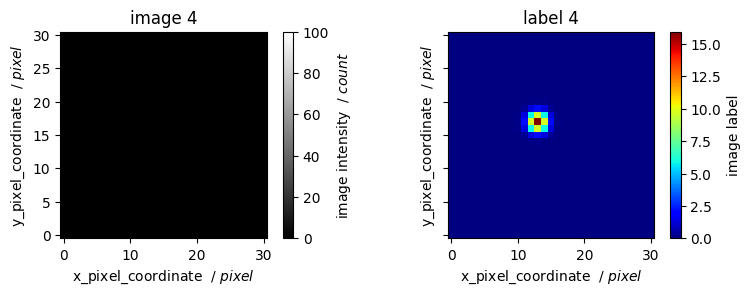

In [10]:
import matplotlib.pyplot as plt

with h5tbx.File(hdf_filename[0], 'r') as h5:
    img_idx = 4
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 3))
    h5['images'][img_idx, :, :].plot(cmap='gray', ax=ax[0], vmax=100)
    h5['labels'][img_idx, :, :].plot(cmap='jet', ax=ax[1])
    ax[0].set_aspect(1)
    ax[1].set_aspect(1)
    ax[0].set_title(f'image {img_idx}')
    ax[1].set_title(f'label {img_idx}')
    plt.tight_layout()
    plt.show()

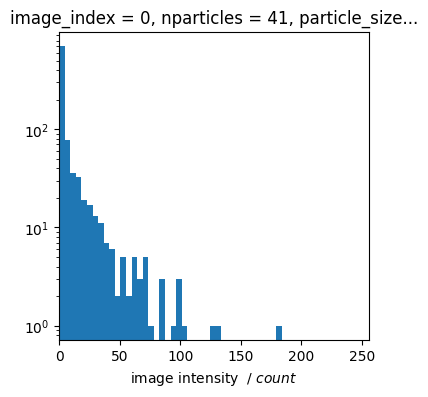

In [11]:
with h5tbx.File(hdf_filename[0], 'r') as h5:
    h5['images'][0, :, :].plot.hist(bins=40, xlim=[0, 2**8], xscale='linear', yscale='log', figsize=(4, 4))